<a href="https://colab.research.google.com/github/mahynski/chemometric-carpentry/blob/main/notebooks/1.4_Statistics_Background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
❓ ***Objective***: This notebook will provide some background in specific statistical ideas and tools.  For more details and information, please refer to the [NIST/SEMATECH e-Handbook of Statistical Methods](https://www.itl.nist.gov/div898/handbook/index.htm).

🔁 ***Remember***: You can always revisit this notebook for reference again in the future.  Ideas and best practices will be reinforced in future notebooks, so don't worry about remembering everything the first time you see something new.

🧑 Author: Nathan A. Mahynski

📆 Date: May 1, 2024

---

# $\chi^2$ Statistics

Recall that we stated many chemometric models, especially those used for authentication, follow a general pattern:

1. ⬇ Perform dimensionality reduction on a training set of data,
2. 💭 Draw a "bubble" around the test data in the lower dimensional space assuming it is normally distributed (usually using a Mahalanobis distance),
3. 📏 Use $\chi^2$ statistics to determine how "far" a sample can be from the center of the distribution and still be considered a class member.

What is the $\chi^2$ [distribution](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3666.htm) and how are we going to use it?  The definition from [Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution) is: If $Z_1$, ..., $Z_k$ are [independent](https://en.wikipedia.org/wiki/Independence_(probability_theory)), [standard normal](https://en.wikipedia.org/wiki/Standard_normal) random variables, then the sum of their squares:

$$
Q = \sum_{i=1}^k Z_i^2
$$

is distributed according to the $\chi^2$ distribution with k degrees of freedom. This is usually denoted as $Q \sim \chi^2(k)$ or $Q \sim \chi_k^2$.  More generally, it can be shown that if $Z_i \sim N(\mu_i, \sigma_i^2)$, then their "autoscaled" values follow a $\chi^2$ distribution:

$$
Q = \sum_{i=1}^k \left( \frac{Z_i - \mu_i}{\sigma_i} \right)^2 \sim \chi^2(k)
$$

## Example

In [73]:
# Select a certain number of degrees of freedom (dimensionality).
k = 5

In [74]:
import numpy as np

# Fix the RNG seed so the same random numbers are generated each time.
np.random.seed(42)

# This is what 1 sample would look like, i.e., one "row" in the "X" matrix.
np.random.normal(size=k)

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337])

In [75]:
# How many samples to draw?
N = 10000

Q = []
Z = np.zeros((N, k))
for i in range(N):
    # Generate k random numbers distributed according to Normal or  Gaussian
    # distribution.
    z = np.random.normal(size=k)
    Z[i,:] = z

    # Store the sum of squares.
    Q.append(np.sum(z**2))

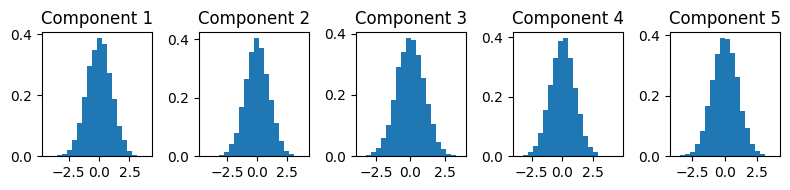

In [77]:
# Let's plot each component of Z so we can see that they are all random and
# normally distributed.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=5, nrows = int(np.ceil(k / 5)), figsize=(8,2))
for i, ax in enumerate(axes.ravel()):
    _ = ax.hist(Z[:,i], bins=20, density=True)
    _ = ax.set_title(f'Component {i+1}')
plt.tight_layout()

In [78]:
from scipy.stats import chi2

def plot_chi2(k, Q):
    fig, ax = plt.subplots(1, 1)

    # Plot the theoretical PDF
    x = np.linspace(chi2.ppf(0.0001, k), chi2.ppf(0.9999, k), 100)
    ax.plot(x, chi2.pdf(x, k), 'r-', lw=5, alpha=0.6, label=r'$\chi^2$({}) PDF'.format(k))

    # Plot the Q values we randomly created
    _ = ax.hist(np.array(Q), bins=50, density=True, label='Randomly Generated')

    plt.xlabel('Q')
    plt.ylabel('P(Q)')
    _ = plt.legend(loc='best')

    return ax

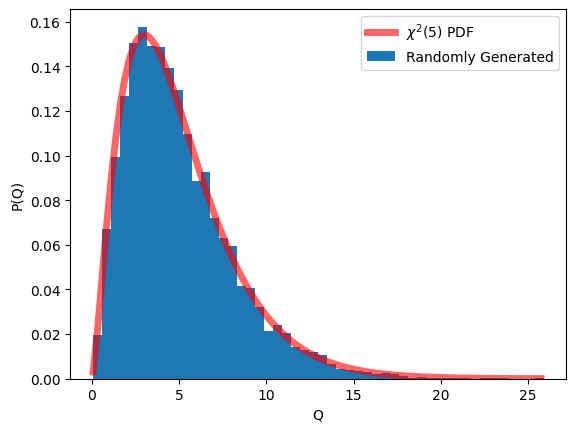

In [79]:
_ = plot_chi2(k, Q)

## Applications

Why does this matter?  Observe that in the general formula above, we are reducing the dimensionality of the data first.  This is usually done through PCA or a similar approach.  The result is data that "lives" in a lower $k$ dimensional space than the one we started with.  The scaled Euclidean distance squared, $D^2$, a given observation is from the center of this data is then given by

$$
D^2 = \sum_{i=1}^k \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2
$$

where $\bar{x}_i$ and $s_i$ are the estimated mean and sample standard deviation, respectively.  The [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) is $k$ dimensions generalizes this "standard score" distance, using a covariance matrix, which can be used to compute $D^2$.Clearly, $D^2 \sim \chi^2(k)$.  

Below is an example from [Wikipedia](https://en.wikipedia.org/wiki/Mahalanobis_distance) showing different different thresholds. More importantly, note that there are several different ways to compute the sample mean and covariance matrix since these can be very sensitive to outliers. The naive way is shown in purple ("non-robust"). Two "robust" methods, the MCD and MVE methods are shown for comparison.  This is related to the process of "cleaning" your data.  Often this involves detection and removal of outliers before modeling can begin so that non-robust methods can be used.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Mahalanobis-distance-location-and-scatter-methods.png/620px-Mahalanobis-distance-location-and-scatter-methods.png" wigth=50/>


⚠ We need to be careful about how we clean the data (remove outliers). 🗣 Here is some more vocabulary:
* Masking - this can occur when we assume there are less outliers than there actually are in the data. For example, if we are setting our limits based on the assumption that a single outlier is present when there are in fact more, these additional outliers may influence the cutoff value (increase it) to the point where it seems like there are NO outliers at all!
* Swamping - this can occur when we assume there are too many outliers in the data. For example, if we are testing for several outliers when there is, in fact, only a single outlier, then the critical distance will be reduced so that many truly inlier points are considered outliers

Some advice straight from [ITL @NIST](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm):
> "Due to the possibility of masking and swamping, it is useful to complement formal outlier tests with graphical methods. Graphics can often help identify cases where masking or swamping may be an issue. Swamping and masking are also the reason that many tests require that the exact number of outliers being tested must be specified.
>
> Also, masking is one reason that trying to apply a single outlier test sequentially can fail. For example, if there are multiple outliers, masking may cause the outlier test for the first outlier to return a conclusion of no outliers (and so the testing for any additional outliers is not performed)."

This is one reason many chemometric methods are accompanied by some graphical tools (more so than most machine learning methods). Certain chemometric tools have data cleaning built in, which is sometimes convenient. Again, this is an art 🎨.

Even after cleaning, we still need to determine he size of the "bubble" in step 2 (illustrated above) - this is often done by selecting a [Type I error rate](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors), $1-\alpha$. In [Hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_test), we are trying to determine if there is sufficient evidence to reject the "null hypothesis", that is, the baseline assumption that is the status quo.  In this application, the status quo is that a sample is expected to be similar to the known samples of an "authentic" class, for example.  A Type I error is when the null hypothesis is rejected, but it is actually true.  In other words, we are rejecting an "authentic" sample as being "inauthentic" even though it was, in fact, actually authentic.  This is set by the user, but typically values of $\alpha = 0.05$ or $\alpha = 0.01$ are selected.

👉 The critical distance we use to determine class membership is then computed from the "percent point function" of the $\chi^2$ distribution.  Recall, this is the limit at which a certain percent of the distribution fall below it.

Though there will be variations, this is a common theme in chemometric models.

In [80]:
alpha = 0.05

d2_crit = chi2.ppf(1 - alpha, df=k)
d2_crit

11.070497693516351

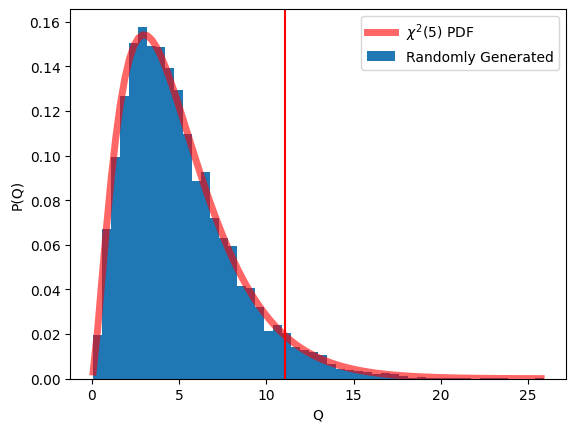

In [81]:
ax = plot_chi2(k, Q)
ax.axvline(d2_crit, color='red')

In [82]:
# Let's see how close we came to 1-alpha being below this cutoff in our sampled
# data.
np.sum(np.array(Q) < d2_crit) / len(Q)

0.9497

# Performance Metrics

## Regression Models

Regression models are often scrored based on their [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), $R^2$.  This can be confusing because $R^2 \neq R*R$.  That is because "$R^2$" is a term defined as:

$$
R^2 \equiv 1 - \frac{SS_{\rm res}}{SS_{\rm tot}}
$$

where $SS_{\rm res}$ is the residual sum of squares, and $SS_{\rm tot}$ is the total sum of squares.  If $\hat{y_i}$ is the predicted value for a point whose true value is $y_i$ then:

$$
SS_{\rm res} = \sum (y_i - \hat{y_i})^2
$$

The total sum of squares is based on the mean value, $\bar{y}$.

$$
SS_{\rm tot} = \sum (y_i - \bar{y})^2
$$

In essence, $R^2$ describes the average accuracy of the model (how close $y_i$ and and $\hat{y_i}$ are) in units of the natural variation of $y$ values around their mean.  This is because the "simplest, reasonable but uninformed" approach to predicting $y_i$ is just to guess the average each time.  We can think of this as a baseline algorithm, so we quantify other models relative to this.

In [43]:
class BaselineRegressor:
    """
    A simple baseline regression model.
    """
    def fit(self, X, y):
        self.average = np.mean(y)
        return self

    def predict(self, X):
        # Ignore X and just predict the average y seen during training.
        return np.array([self.average]*X.shape[0])

def r2(model, x, y):
    """
    Compute the coefficient of determination.
    """
    ss_res = np.sum((y - model.predict(x))**2)
    ss_tot = np.sum((y - np.mean(y))**2)

    return 1.0 - ss_res/ss_tot

In [63]:
import numpy as np
np.random.seed(42)

# Create some dummy linear data.
x = np.linspace(0, 10, 100).reshape(-1,1) # sklearn expects this as a column
y = 3.2*x.ravel() + 4.1 + np.random.normal(size=x.shape[0])

# Now let's fit a linear model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
_ = lr.fit(x, y)

# Check this learned the similar coefficients we used to generate the data.
print(lr.coef_, lr.intercept_)

[3.21379327] 3.927187145922627


In [64]:
print(
    lr.score(x, y), # This function's score return the R^2 value.
    r2(lr, x, y) # Our manual calculation
)

0.9908049479870445 0.9908049479870445


In [65]:
# The baseline model has R^2 = 0.
base = BaselineRegressor()
_ = base.fit(x, y)

r2(base, x, y)

In [70]:
# What if we created an algorithm that generates random guesses instead?
class Guesser:
    """
    A model which just makes random guesses.
    """
    def __init__(self, seed=42):
        self.rng = np.random.default_rng(seed=seed)

    def fit(self, X, y):
        # Learn nothing!
        return self

    def predict(self, X):
        # Ignore X and just predict the average y seen during training.
        return self.rng.normal(size=X.shape[0])

In [72]:
# R^2 is actually < 0!  This is because you can do worse than guessing the mean
# of the response.
guess = Guesser()
r2(guess, x, y)

-4.566646416969218

---
> ❗ For regression models, you should think of "guessing the average" as the standard reference algorithm all other algorithms will be compared against.  The bounds on the coefficient of determination are actually, $-\infty < R^2 \le 1$, not $0 \le R^2 \le 1$!
---

## Classification Models

There are numerous types of classification models we encounter in chemometrics, e.g., multiclass vs. multilabel.  Depending on the model, different metrics may be needed to explain the performance of the model. Even before we get to that we need to address the analog of the $R^2$ dilemma we just saw.  

🤔 For classification models, what is the "simplest, reasonable but uninformed" algorithm we could use to guess the answer?

🙋 For classification models, this amounts to just guessing the most commonly observed class.

In fact, many classification models, in an attempt to learn something, accidentlaly pick up on this and end up biased.  This is why "class imbalance" is so important to monitor when training classification models.  

In [ ]:
class BaselineClassifier:
    """
    A simple baseline classification model.
    """
    def fit(self, X, y):
        self.most_common = max(set(y), key = y.count)
        return self

    def predict(self, X):
        # Ignore X and just predict the most_common y seen during training.
        return np.array([self.most_common]*X.shape[0])

In [ ]:
data_bunch = load_stamp2010()

In [2]:
# Let's examine a toy dataset.
from sklearn import datasets
X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

In [20]:
# This dataset is perfectly balanced.
y.value_counts()

# ... let's change that.
import pandas as pd
mask = y == 2
X_un = pd.concat((X[~mask], X[mask][:10]))
y_un = pd.concat((y[~mask], y[mask][:10]))

y_un.value_counts()

target
0    50
1    50
2    10
Name: count, dtype: int64

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_balanced = RandomForestClassifier(n_estimators=10)
rf_balanced

### The Confusion Matrix

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) describes the performance of a classifier.  The properties of this matrix will change depending on what sort of classifier is being used.  The differences will be reviewed for each category below, but for now let's look at the basics. Consider a case where we have 2 classes: P (positive) and N (negative).  A confusion matrix will be 2x2 and have entries labeled like this:

| | Predicted P | Predicted N |
|---|---|---|
| Actual P | TP | FN |
| Actual N | FP | TN |

The columns represent the number of times a point was predicted to be in each class (here, P or N).  The rows correspond to the actual value of these observations.  In this example we have only 2 classes (binary) which are assumed to be mutually exclusive; however, we may have models with more (multiclass), or classes that are not mutually exclusive (multilabel).

* TP = True Positives; these are points that are predicted to be class P and are, in fact, members of class P.
* FN = False Negatives; these are points that are predicted to be class N but are, in fact, members of class P.
* FP = False Positives; these are points that are predicted to be class P but are, in fact, members of class N.
* TN = True Negatives; these are points that are predicted to be class N and are, in fact, members of class N.

👉 We can combine elements of this confusion matrix to get different performance metrics.

💡 When there are more than 2 classes performance metrics can be weighted "microscopically" or "macroscopically" based on the performance on individual classes using a OvA approach; e.g., see [sklearn's documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel).  However, as this is less common in chemometrics we will not focus on such metrics in this course.  Instead the "false" categories are often simply extended to include all points that are predicted to be a certain class but are not truly members.  The "true" categories still only include cases when a point is correctly predicted.



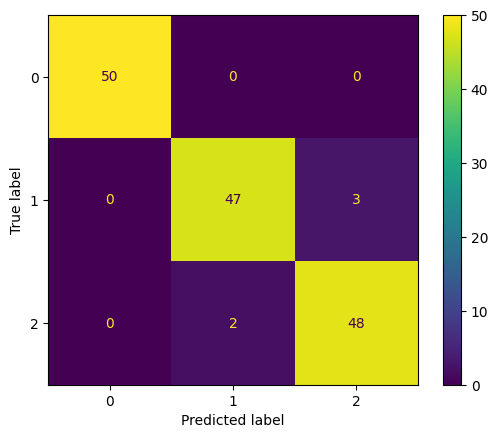

In [25]:
# Let's examine a toy dataset with 3 classes.
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

# Let's train a simple nearest-neighbor classifier.
X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

# It is very simple to plot this matrix with sklearn.
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(model, X, y)

### Binary and Multiclass Classifiers

For certain models, we will train using multiple (>2) classes.  These can be used under a variety of settings, but most authentication tasks are handled with one-class classifiers (OCC).  For OCCs, we effectively have a binary prediction (e.g., authentic or not) where the results are mutually exclusive.

#### Common Single-Valued Metrics

For these cases the model assigns each point to a single class (column in the confusion matrix).  As a result, the row-wise sums yield to the total number of each class: $P = TP + FN$, $N = FP + TN$.

One of the most common metrics for assessing the performance of these (closed set) classifiers is with accuracy (ACC):

$$
ACC = \frac{{\rm correct~predictions}}{{\rm total~number~of~predictions}} = \frac{TP+TN}{TP+FN+FP+TN}
$$

For imbalanced systems the true positive (TPR) and false positive rate (FPR) can be very helpful.  These are related to the concepts of [sensitivity (SNS) and specificity (SPS)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) which are also commonly used. SNS refers to how often a point is correctly assigned the category it belongs to, while SPS refers to how often incorrect assignments are avoided.  We usually consider good classifiers to be both sensitive and specific.

$$
FPR = \frac{FP}{FP + TN}
$$

$$
TPR = \frac{TP}{FN + TP} = SNS = REC
$$

Sometimes the term "recall" (REC) is also used to refer to the TPR. The true negative rate (TNR) is equivalent to specificity and complementary to FPR.  This is very important for multilabel classifiers.

$$
TNR = \frac{TN}{FP + TN} = SPS = 1 - FPR
$$

For example, it might be important to optimize the TPR so all examples of a class are detected even if that means we also falsely include some non-members of that class.  In authentication, the opposite is often true - we want to make sure the FPR is low because a false positive means accepting a sample as authentic when it is a fake.  In this case, this comes at the possible cost of rejecting more truly authentic ones.  In commerce, the impact this has on consumers and producers needs to be balanced.

$$
PRE = \frac{TP}{TP + FP}
$$

Precision is a similar concept as SPS, but is less commonly used in chemometrics.  Since "good" models generally have a good balance of SNS and SPS (or REC and PRE), these values are often combined.  The [F1 score](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) is commonly used in machine learning, though "Efficiency" is often used for chemometric models (addressed in the next section).

$$
F1 = 2 \frac{PRE \times REC}{PRE + REC}
$$

Unlike the SPS vs SNS tradeoff, PRE and REC are both independent of the TNR.  If true negative rates are hard to reliably estimate then this may be a better metric to use; for [sitations with unbalanced classes this can be misleading](https://en.wikipedia.org/wiki/F-score).


👉 This is a lot of terminology, but in chemometrics it seems be most common to refer to models in terms of their SNS and SPS.  Still, it is good to know how these connect to terms in other fields.

#### Chemometric Efficiency

 find citations / invetion of efficiency in chemometric fiel

 simca accuracy ~ TEFF (see SI from pgaa paper)

#### ROC and Related Curves

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png" width = 400, align = "right"/>  Another common metric is the "receiver operating characteristic" [(ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) in [binary classification](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).  This is a plot of the TPR (or SNS) on the y-axis vs. the FPR (or 1 - SPS) as hyperparameters, such as class membership threholds, are changed.  At the right is an example from Wikipedia.

A perfect model as TPR = 1 and FPR = 0 (top left corner).  By integrating the area under the ROC curve (AUROC) we can characterize the performance of a model relative to this perfect case where AUROC = 1.

The accuracy score can be interpreted as just a single point on the ROC curve.  It is also possible to compute the [area under the precision-recall (AUPRC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).  It is a common adage that the AUPRC is a better metric for binary classification tasks when class imbalance exists, but [this has been challenged recently](https://arxiv.org/abs/2401.06091).

These curves are less commonly using in chemometric settings.



### Multilabel Classifiers

Since multilabel classifiers can assign an actual point to multiple categories (columns), it is no longer true that the row-wise sums add up to the total number of members of each class: $P \ne TP + FN$, $N \ne FP + TN$.

If a model can assign a point to multiple categories, consider 2 extremes:

1. A model which assigns every point to every category.  This has high SNS since the model assigns each point to its correct category; however, it has a very low SPS because it also assigns it to every other category, too.  You can think of such a model as having an "infinitely large bubble" around all modeled class centers so all points are always included.  A confusion matrix would look like this (here there are 10 A's, 20 B's, and 30 C's):

| | Predicted A | Predicted B | Predicted C |
| --- | --- | --- | --- |
| Actual A | 10 | 10 | 10 |
| Actual B | 20 | 20 | 20 |
| Actual C | 30 | 30 | 30 |

2. A model which assigns no point to any category.  This has SPS = 1 since it completely avoids falsely assigning points to the wrong categories; however, it has a SNS = 0 because it also fails to assign any point to its correct category, too.  You can think of such a model as having an "infinitely small bubble" around all modeled class centers so no points are ever included.  A confusion matrix would look like this:

| | Predicted A | Predicted B | Predicted C |
| --- | --- | --- | --- |
| Actual A | 0 | 0 | 0 |
| Actual B | 0 | 0 | 0 |
| Actual C | 0 | 0 | 0 |

👉 Obviously, these two extremes are trivial. In reality we want to find a balance; essentially, we want the "bubble" around each modeled class center to be "big enough" to include many true members, but not so big it includes others.  This is easiest when the class centers in your model are small and separated by large distances.  The art 🎨 is building a model that has these features!


EFF

also soft plsda differences

class vs. total

# Rashomon sets